# 决策树

**决策树**（**decision tree**）是一类非常常见的机器学习算法，如果被预测的变量为离散变量，通常也称**分类树**（**classification tree**），如果被预测的变量为连续变量，通常也称为**回归树**（**regression tree**）。

这类算法的思想是使用一种称为**树**（**tree**）的结构对进行预测，实际上相当于对特征空间进行了一些划分，对于每一块划分的区域可以保证其特征比较类似，因而可以用于预测。

为了直观理解这一算法，我们不妨先借用以上的数据做一个简单的模型：

In [1]:
import pandas as pd
raw_data=pd.read_csv("csv/soep.csv")

import numpy as np
data=raw_data.set_index(['persnr','year'])
data['log_income']=np.log(data['income'])
data['age2']=np.power(data['age'],2)
data=data.drop('income',axis=1)
region_dummy=pd.get_dummies(data['region'])
data=pd.concat([data,region_dummy], axis=1)
data=data.drop(['region','0'],axis=1)
data['employment']=data['employment']==data['employment'][0]
data

employment  chld6  chld16  age  husworkhour  husemployment  \
persnr  year                                                               
9401    2008        True      0       0   48         1923              1   
        2009        True      0       0   49         2078              1   
        2010        True      0       0   50         2078              1   
        2011        True      0       0   51         2494              1   
        2012        True      0       0   52         2078              1   
...                  ...    ...     ...  ...          ...            ...   
8270802 2008        True      0       0   23         2078              1   
        2009        True      0       0   24         2078              1   
        2010        True      0       0   25         2078              1   
        2011        True      0       0   26         2078              1   
        2012        True      0       0   27         2078              1   

               edu  husedu  log_income  age2  [1] West-Germany   1  
persnr  year                                                        
9401    2008  13.0    12.0   10.833326  2304                     0  
        2009  13.0    12.0   10.733785  2401                     0  
        2010  13.0    12.0   10.793229  2500                     0  
        2011  13.0    12.0   10.874872  2601                     0  
        2012  13.0    12.0   10.929350  2704                     0  
...            ...     ...         ...   ...                   ...  
8270802 2008  11.5    11.5   10.264861   529                     0  
        2009  11.5    11.5   10.079539   576                     0  
        2010  11.5    11.5   10.103240   625                     0  
        2011  11.5    11.5   10.090880   676                     0  
        2012  11.5    11.5   10.242813   729                     0  

[6705 rows x 11 columns]

In [2]:
y=data['employment']
X=data.drop('employment',axis=1)

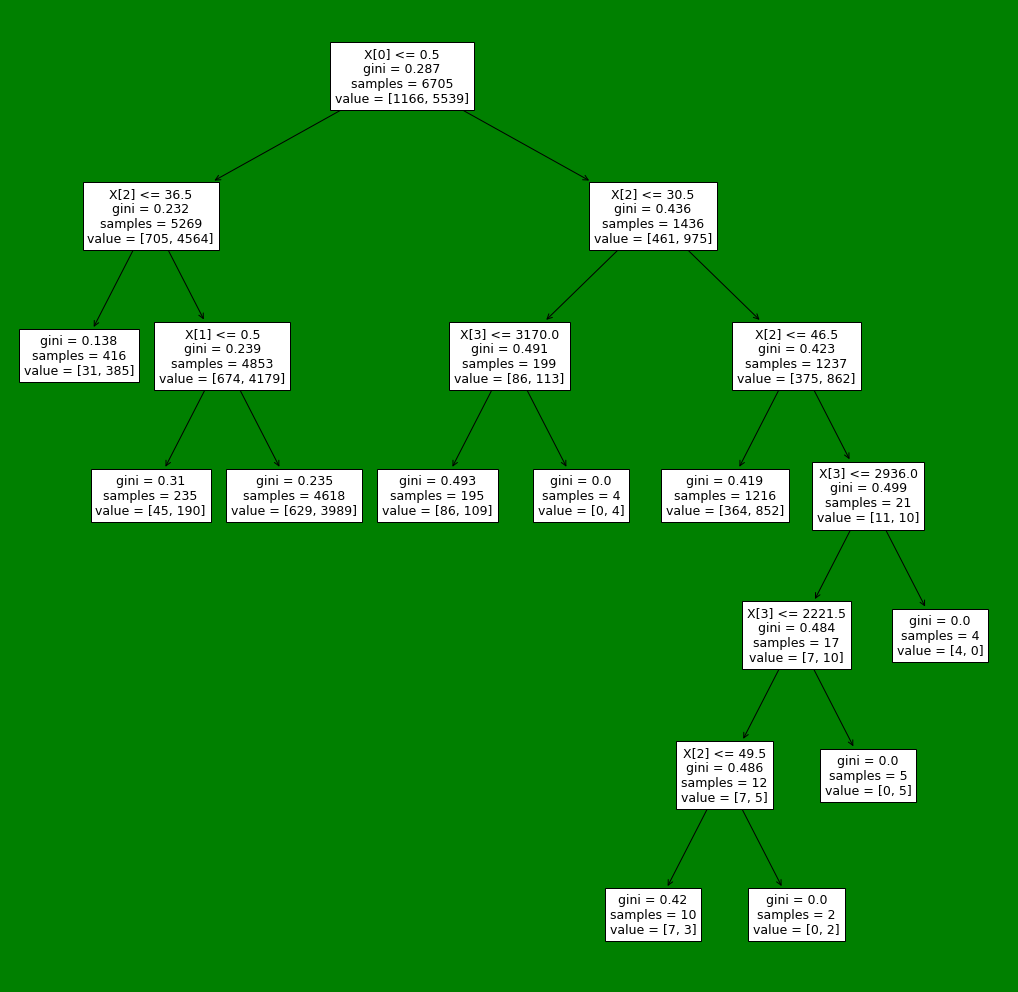

In [3]:
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline
dtree=tree.DecisionTreeClassifier(max_leaf_nodes=10) ##设定最大的叶子数，10
X_example=X[['chld6','husemployment','age','husworkhour']] ##先选3个特征，注意特征中age为连续变量
dtree.fit(X_example,y) ##训练
fig, ax = plt.subplots(figsize=(18, 18), facecolor='g')
tree.plot_tree(dtree, ax=ax) ##画图
plt.show()

上图给出了限定叶子数为10的时候的分类树的结果。其中最上层的节点一般称为**根节点**（**root node**），接下来的是若干子节点，而最终没有自己点的称为**叶节点**（**leaf nodes**）。而从每一个子节点开始，都可以看做是一颗新的树，或者**子树**（**subtree**）。

注意到每个节点都有一个value，代表的是在这个节点上两种分类的样本数量。

回归树的原理是，在每一个节点，通过一定算法，找到能够使得分类更加明确的标准，然后根据这一标准进行分类。其中评价分类是否更加明确的指标通常有Gini系数和熵（DecisionTreeClassifier的criterion选项控制，可以选择'gini'或者'entropy'）。

分出子节点后，子节点又可以看做是一颗新的树，继续查看信息的增益（即分类更加明确的标准），继续分类，以此类推。

然而需要注意的是，树不可能无限的延长，过于长的树非常容易导致过拟合问题，因而有必要对树进行**剪枝**（**pruning**）。或者，实践中也可以在模型设定时限制树的大小，比如：

* max_depth: 最大深度，默认不限制
* max_features: 最多取多少特征，默认不限制，可以提供一个整数，也可以选择：
    - 'auto'：等价于'sqrt'
    - 'sqrt'：特征数的开平方
    - 'log2'：log2(特征数)
* max_leaf_nodes: 叶子的最大个数，默认不限制，可以提供一个整数限制
* min_impurity_decrease: 默认为0，只有当Gini系数或者熵的降低大于这个数字时才产生下一个节点，否则就作为叶子节点

分类树最终的结果是对特征空间进行了一些划分，并使用这些划分作为预测。下面的代码中，我们选取了两个特征，然后将两个特征的划分画出来以直观展示这种划分：

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


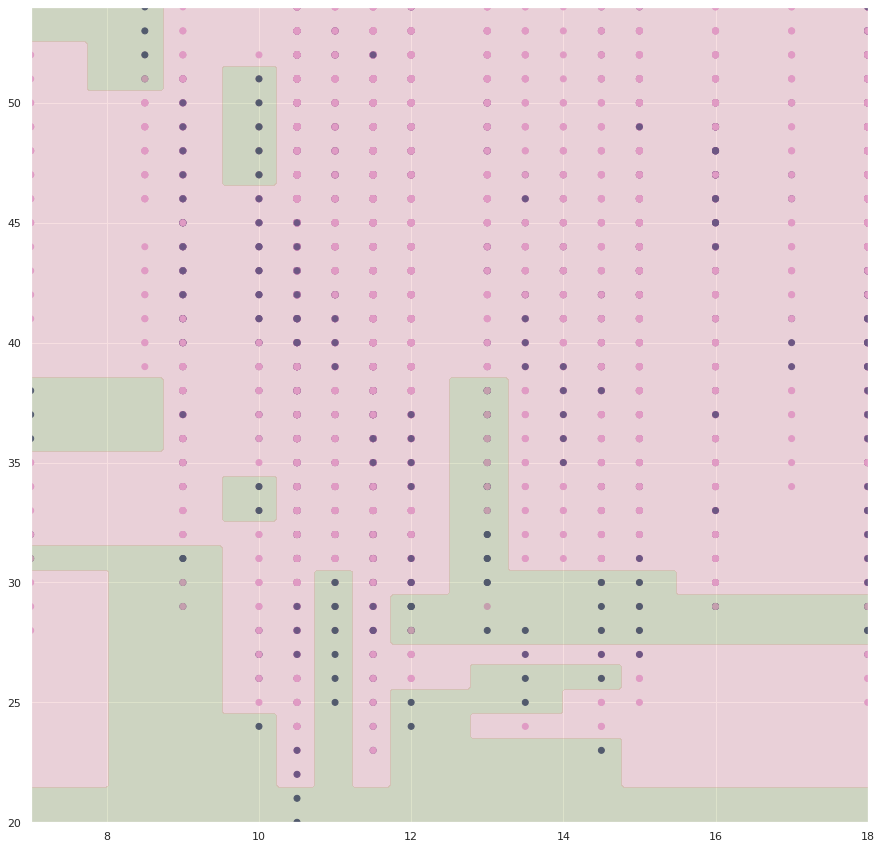

In [4]:
def tree_partion_graph(X, y, figsize_x=15, figsize_y=15):
    import matplotlib.pyplot as plt
    import seaborn as sb
    sb.set()
    plt.rcParams['figure.figsize'] = (figsize_x, figsize_y)
    plt.scatter(X.iloc[:,0],X.iloc[:,1], c=y, cmap='tab20b')
    xx,yy=np.meshgrid(np.linspace(X.iloc[:,0].min(),X.iloc[:,0].max(), num=200),np.linspace(X.iloc[:,1].min(),X.iloc[:,1].max(), num=200))
    xx=xx.reshape(xx.size,1)
    yy=yy.reshape(yy.size,1)
    dtree=tree.DecisionTreeClassifier(max_leaf_nodes=80) ##设定最大的叶子数，10
    dtree.fit(X,y) ##训练
    Z=dtree.predict(np.hstack([xx,yy]))
    plt.xlim(X.iloc[:,0].min(),X.iloc[:,0].max())
    plt.ylim(X.iloc[:,1].min(),X.iloc[:,1].max())
    Z=Z.reshape(200,200)
    xx=xx.reshape(200,200)
    yy=yy.reshape(200,200)
    print(Z)
    plt.contourf(xx,yy,Z,alpha=0.3,levels=np.arange(len(np.unique(y))+1)-0.5,cmap='tab20b',zorder=1)
    plt.show()
    
tree_partion_graph(data[['husedu','age']], data['employment'])

当然，与Logistic回归一样，也可以计算ROC曲线等等：

TP= 5489
TN= 258
FP= 908
FN= 50
查全率=敏感性= 0.9909730998375158
查准率= 0.8580584649054244
特异性= 0.22126929674099485


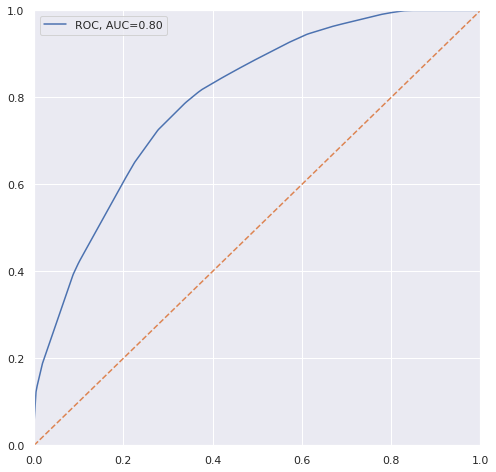

In [5]:
raw_data=pd.read_csv("csv/soep.csv")
raw_data.head()
data=raw_data.set_index(['persnr','year'])
region_dummy=pd.get_dummies(data['region'])
data=pd.concat([data,region_dummy], axis=1)
data=data.drop(['region','0'],axis=1)
data['employment']=data['employment']==data['employment'][0]
y=data['employment']
X=data.drop('employment',axis=1)
dtree=tree.DecisionTreeClassifier(max_depth=8) ##设定最大深度
dtree.fit(X,y) ##训练
## 预测及概率
data['prob']=dtree.predict_proba(X)[:,1]
data['pred']=dtree.predict(X)
## 计算指标
TP=np.sum(data['employment'] & data['pred'])
TN=np.sum((~data['employment'] & (~data['pred'])))
FP=np.sum((~data['employment'] & (data['pred'])))
FN=np.sum((data['employment']) & (~data['pred']))

print("TP=",TP)
print("TN=",TN)
print("FP=",FP)
print("FN=",FN)
print("查全率=敏感性=",TP/(TP+FN))
print("查准率=",TP/(TP+FP))
print("特异性=",TN/(TN+FP))

## 画图
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(data['employment'], data['prob'])
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.plot(fpr,tpr,label='ROC, AUC=%.2f' % roc_auc)
plt.legend(loc='upper left', frameon=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

需要注意的是，以上虽然看起来好像AUC提高了很多，但是其实这可能是由于过拟合导致的。如果对样本外做ROC曲线并进行比较可能更加能反应模型的好坏。

最后，决策树也可以做回归，即sklearn.tree.DecisionTreeRegression()，这里不再赘述。

# 样本外预测与参数选择

实际应用时，我们并不知道应该如何确定一个分类树的参数。如果树的深度太深很容易造成过拟合，而如果树太小，又不能充分利用信息造成欠拟合。一个切实可行的解决办法是使用交叉验证。

比如，我们可以选取不同的max_depth、max_leaf_nodes或者min_impurity_decrease，使用交叉验证的方法查看每种设定下的样本外预测精度，从中选取一个样本外预测精度最高的模型。接下来我们以样本外的AUC作为性能度量，通过设定不同的min_impurity_decrease，每次做10折交叉验证，找到最适合的参数。

In [6]:
X['employment']=y
X=X.sort_index()
X=X.unstack()
X['random_order']=np.random.random(X.shape[0])
X=X.sort_values(['random_order'])
X=X.drop('random_order', axis=1)
X

chld6                     chld16                      ...  \
year     2008 2009 2010 2011 2012   2008 2009 2010 2011 2012  ...   
persnr                                                        ...   
3275902     0    0    0    0    0      2    2    2    2    2  ...   
175003      0    0    0    0    0      2    2    2    1    1  ...   
3029002     0    0    0    0    0      1    1    1    0    0  ...   
5138602     0    0    0    0    0      0    0    0    0    0  ...   
1080102     1    1    1    1    1      0    0    0    0    1  ...   
...       ...  ...  ...  ...  ...    ...  ...  ...  ...  ...  ...   
2614902     1    1    1    0    0      2    1    1    2    2  ...   
2851702     0    0    0    0    0      0    0    0    0    0  ...   
587307      1    1    0    0    0      1    1    2    2    2  ...   
155204      1    1    1    0    1      0    0    0    1    1  ...   
2648202     1    0    0    0    0      2    3    3    3    3  ...   

        [1] West-Germany   1                     employment                \
year                    2008 2009 2010 2011 2012       2008   2009   2010   
persnr                                                                      
3275902                    0    0    0    0    0       True   True   True   
175003                     0    0    0    0    0       True   True   True   
3029002                    1    1    1    1    1       True   True   True   
5138602                    1    1    1    1    1       True   True   True   
1080102                    0    0    0    0    0      False  False  False   
...                      ...  ...  ...  ...  ...        ...    ...    ...   
2614902                    0    0    0    0    0       True   True   True   
2851702                    0    0    0    0    0       True   True   True   
587307                     0    0    0    0    0      False  False  False   
155204                     0    0    0    0    0       True   True   True   
2648202                    0    0    0    0    0      False  False  False   

                       
year      2011   2012  
persnr                 
3275902   True   True  
175003    True   True  
3029002   True   True  
5138602   True   True  
1080102  False  False  
...        ...    ...  
2614902   True   True  
2851702   True   True  
587307    True   True  
155204    True   True  
2648202  False  False  

[1341 rows x 50 columns]

In [7]:
from sklearn.model_selection import KFold
X=X.stack()
for i in range(10):
    mid=(i+1)/5000 ## mid=0.05,0.1,0.15,...,0.5
    ## 区分训练集和测试集
    kf = KFold(n_splits=10)
    X=X.unstack()
    CV_prob=np.array([])
    for train, test in kf.split(X):
        ## 使用训练集回归
        X_train=X.iloc[train,:].stack()
        X_test=X.iloc[test,:].stack()
        # 先使用训练集训练模型
        dtree=tree.DecisionTreeClassifier(min_impurity_decrease=mid).fit(X_train.drop('employment',axis=1),X_train['employment'])
        # 接下来在验证集上进行预测，得到预测概率
        pre_prob=dtree.predict_proba(X_test.drop('employment',axis=1))[:,1]
        CV_prob=np.concatenate([CV_prob,pre_prob])
    X=X.stack()
    fpr, tpr, threshold = roc_curve(X['employment'], CV_prob)
    roc_auc = auc(fpr, tpr)
    print("mid=%.5f, AUC=%.5f" % (mid, roc_auc))

mid=0.00020, AUC=0.56809
mid=0.00040, AUC=0.64689
mid=0.00060, AUC=0.65007
mid=0.00080, AUC=0.63159
mid=0.00100, AUC=0.63311
mid=0.00120, AUC=0.62389
mid=0.00140, AUC=0.61776
mid=0.00160, AUC=0.61663
mid=0.00180, AUC=0.61847
mid=0.00200, AUC=0.61735


可以看到当min_impurity_decrease取0.0006的时候，样本外预测能力似乎达到了最大值，因而我们可以使用该参数进行训练：

TP= 5489
TN= 181
FP= 985
FN= 50
查全率=敏感性= 0.9909730998375158
查准率= 0.8478529502625888
特异性= 0.15523156089193826


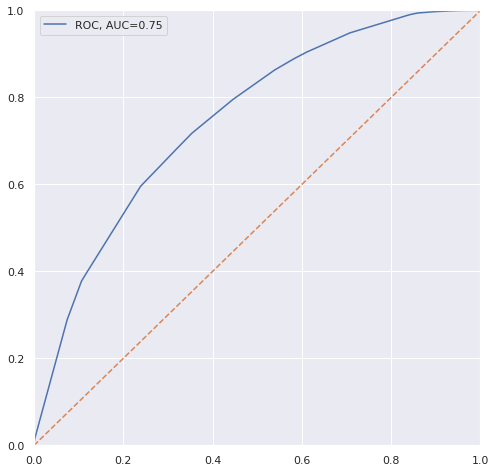

In [8]:
dtree=tree.DecisionTreeClassifier(min_impurity_decrease=0.0006).fit(X.drop('employment',axis=1),X['employment'])

prob=dtree.predict_proba(X.drop('employment',axis=1))[:,1]
pred=dtree.predict(X.drop('employment',axis=1))
## 计算指标
TP=np.sum(X['employment'] & pred)
TN=np.sum((~X['employment'] & (~pred)))
FP=np.sum((~X['employment'] & (pred)))
FN=np.sum((X['employment']) & (~pred))

print("TP=",TP)
print("TN=",TN)
print("FP=",FP)
print("FN=",FN)
print("查全率=敏感性=",TP/(TP+FN))
print("查准率=",TP/(TP+FP))
print("特异性=",TN/(TN+FP))

## 画图
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(X['employment'], prob)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.plot(fpr,tpr,label='ROC, AUC=%.2f' % roc_auc)
plt.legend(loc='upper left', frameon=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

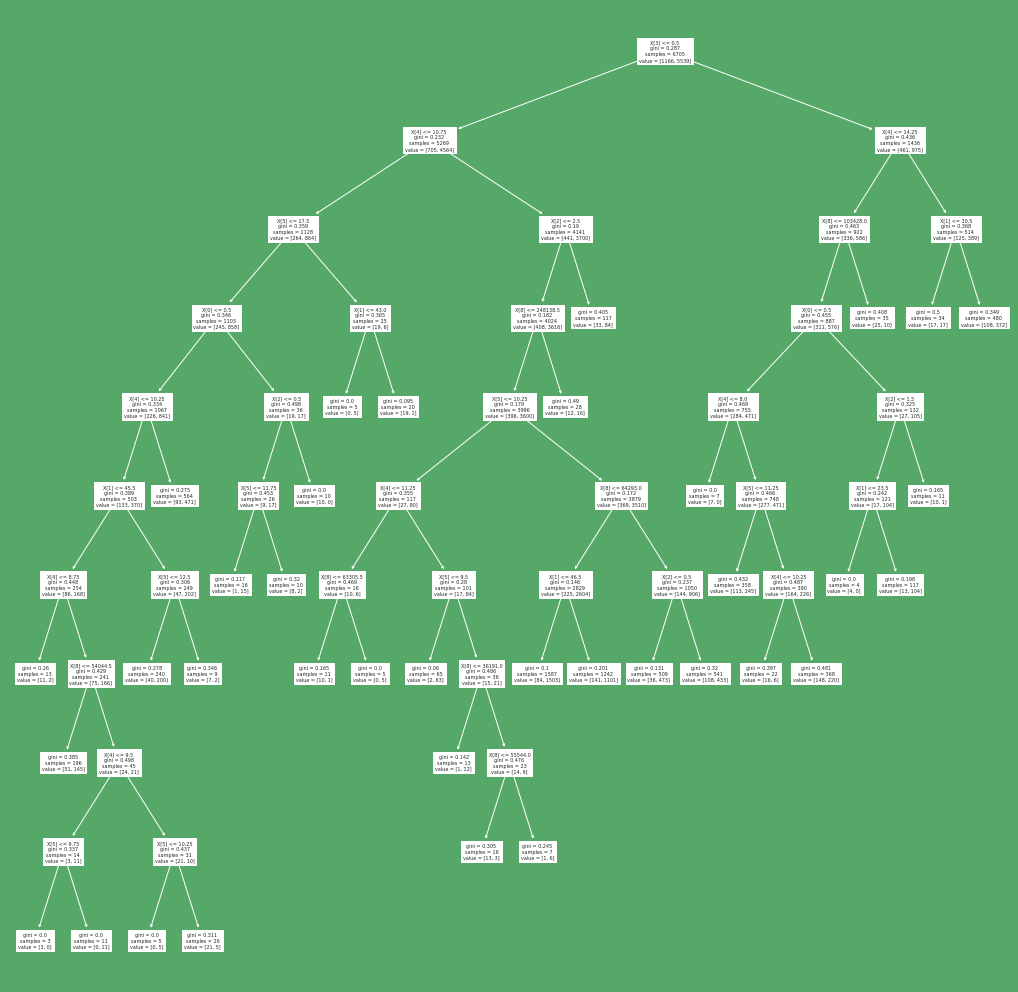

In [9]:
fig, ax = plt.subplots(figsize=(18, 18), facecolor='g')
tree.plot_tree(dtree, ax=ax) ##画图
plt.show()

# 随机森林

决策树虽然看起来是一种非常flexible的建模方法，但是也面临着过拟合等问题，剪枝策略也非常容易影响最终效果。为了解决这些问题，我们可以在决策树的基础上进行进一步拓展。

其中的一种做法是**bagging**。Bagging首先通过自助法（bootstrap）的方法对**样本**进行**有放回**抽样（从而抽样得到的样本是可以重复的）抽出$m$个样本，然后使用抽样的样本训练数据集，得到一个模型。

重复以上步骤M次，就可以得到$M$个模型，使用这$M$个模型可以得到$M$个预测结果，然后使用这$M$个预测结果投票即可得到最终结果。

此外，由于Bagging采用了有放回抽样，因而样本中有的样本被抽到多次，有的没有抽到，此时剩下的没有抽到的样本可以用来度量样本外预测能力，即包外估计（out-of-bag estimate）。

以上思路不仅仅对决策树可行，很多机器学习算法都可以使用以上方法改进预测。

在bagging的基础上，**随机森林**（**random forest**）更近了一步。Bagging仅仅在样本中进行有放回抽样，而随机森林则进一步在特征空间中随机抽取特征，即同样重复建立$M$个决策树，每个决策树随机挑选$k$个特征，并使用有放回的抽样方法抽取样本，训练模型。最终$M$个模型通过平均、投票的方式得到最终的估计。一般而言，$k$的选取可以使用一个rule of thumb: $k=\log_2 K$

随机森林实现非常简单，计算量也不大，重要的是预测效果非常好！

比如对于以上数据，使用scikit-learn可以轻松完成随机森林的建模：

TP= 5539
TN= 366
FP= 800
FN= 0
查全率=敏感性= 1.0
查准率= 0.8737971288846821
特异性= 0.313893653516295


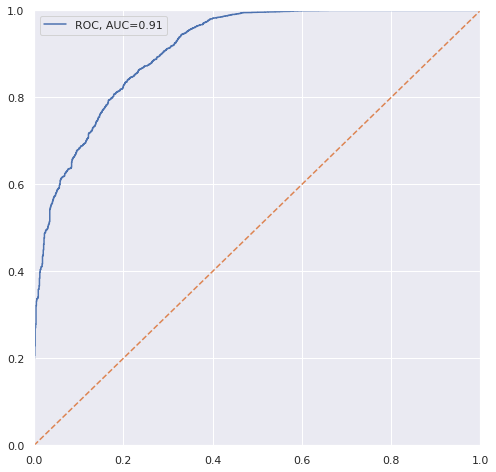

In [10]:
from sklearn.ensemble import RandomForestClassifier
##100颗树，特征数量为总数量的log2，本例中总共9个特征所以每个模型为3，每棵树最大深度为10
##oob_score=True代表使用为进入bootstrap样本的观测对模型进行评价（out-of-bagging score）
rfc=RandomForestClassifier(n_estimators=100, max_features='log2', oob_score=True, max_depth=10)
y=data['employment']
X=data.drop(['employment','pred','prob'],axis=1)
rfc.fit(X,y)
## 预测及概率
data['prob']=rfc.predict_proba(X)[:,1]
data['pred']=rfc.predict(X)
## 计算指标
TP=np.sum(data['employment'] & data['pred'])
TN=np.sum((~data['employment'] & (~data['pred'])))
FP=np.sum((~data['employment'] & (data['pred'])))
FN=np.sum((data['employment']) & (~data['pred']))

print("TP=",TP)
print("TN=",TN)
print("FP=",FP)
print("FN=",FN)
print("查全率=敏感性=",TP/(TP+FN))
print("查准率=",TP/(TP+FP))
print("特异性=",TN/(TN+FP))

## 画图
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(data['employment'], data['prob'])
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.plot(fpr,tpr,label='ROC, AUC=%.2f' % roc_auc)
plt.legend(loc='upper left', frameon=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

为了避免过拟合，我们同样可以使用交叉验证来选取适当的参数，比如特征的个数：

In [11]:
X['employment']=y
X=X.sort_index()
X=X.unstack()
X['random_order']=np.random.random(X.shape[0])
X=X.sort_values(['random_order'])
X=X.drop('random_order', axis=1)
X

chld6                     chld16                      ...  \
year     2008 2009 2010 2011 2012   2008 2009 2010 2011 2012  ...   
persnr                                                        ...   
2571202     0    0    0    0    0      3    2    2    2    1  ...   
2720702     0    0    0    0    0      0    0    0    0    0  ...   
2731102     0    0    0    0    0      2    1    1    1    0  ...   
5623502     1    1    1    1    1      0    1    1    1    1  ...   
5173002     0    0    0    0    0      0    0    0    0    0  ...   
...       ...  ...  ...  ...  ...    ...  ...  ...  ...  ...  ...   
5109602     0    0    0    0    0      1    1    1    1    1  ...   
2859402     0    0    0    0    0      0    0    0    0    0  ...   
5187602     0    0    0    0    0      0    0    0    0    0  ...   
3338102     0    1    1    1    1      0    0    0    0    0  ...   
2887701     1    1    1    1    1      2    2    2    3    3  ...   

        [1] West-Germany   1                     employment                \
year                    2008 2009 2010 2011 2012       2008   2009   2010   
persnr                                                                      
2571202                    0    0    0    0    0      False  False  False   
2720702                    0    0    0    0    0       True   True   True   
2731102                    0    0    0    0    0       True   True   True   
5623502                    1    1    1    1    1       True   True   True   
5173002                    1    1    1    1    1       True   True   True   
...                      ...  ...  ...  ...  ...        ...    ...    ...   
5109602                    1    1    1    1    1      False  False  False   
2859402                    0    0    0    0    0       True   True   True   
5187602                    1    1    1    1    1       True   True   True   
3338102                    0    0    0    0    0       True   True  False   
2887701                    0    0    0    0    0       True   True   True   

                       
year      2011   2012  
persnr                 
2571202  False  False  
2720702   True   True  
2731102   True   True  
5623502   True  False  
5173002   True   True  
...        ...    ...  
5109602  False  False  
2859402   True   True  
5187602   True   True  
3338102  False  False  
2887701   True   True  

[1341 rows x 50 columns]

In [12]:
X=X.stack()
for i in range(9):
    ## 区分训练集和测试集
    kf = KFold(n_splits=10)
    X=X.unstack()
    CV_prob=np.array([])
    for train, test in kf.split(X):
        ## 使用训练集回归
        X_train=X.iloc[train,:].stack()
        X_test=X.iloc[test,:].stack()
        # 先使用训练集训练模型
        rfc=RandomForestClassifier(n_estimators=100, max_features=i+1,oob_score=True, max_depth=10).fit(X_train.drop("employment", axis=1),X_train['employment'])
        # 接下来在验证集上进行预测，得到预测概率
        pre_prob=rfc.predict_proba(X_test.drop('employment',axis=1))[:,1]
        CV_prob=np.concatenate([CV_prob,pre_prob])
    X=X.stack()
    fpr, tpr, threshold = roc_curve(X['employment'], CV_prob)
    roc_auc = auc(fpr, tpr)
    print("max_features=%d, AUC=%.5f" % (i+1, roc_auc))

max_features=1, AUC=0.67506
max_features=2, AUC=0.68176
max_features=3, AUC=0.68329
max_features=4, AUC=0.68198
max_features=5, AUC=0.68033
max_features=6, AUC=0.67489
max_features=7, AUC=0.67403
max_features=8, AUC=0.67161
max_features=9, AUC=0.67009


TP= 5538
TN= 262
FP= 904
FN= 1
查全率=敏感性= 0.9998194619967503
查准率= 0.8596709096553865
特异性= 0.22469982847341338


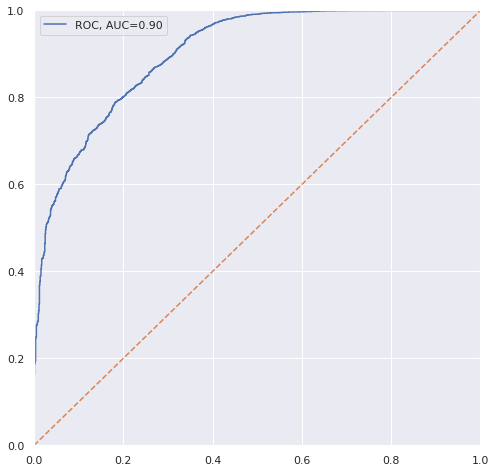

In [13]:
rfc=RandomForestClassifier(n_estimators=100, max_features=2,oob_score=True, max_depth=10)
rfc.fit(X.drop("employment", axis=1),X['employment'])
## 预测及概率
prob=rfc.predict_proba(X.drop('employment',axis=1))[:,1]
pred=rfc.predict(X.drop('employment',axis=1))
## 计算指标
TP=np.sum(X['employment'] & pred)
TN=np.sum((~X['employment'] & (~pred)))
FP=np.sum((~X['employment'] & (pred)))
FN=np.sum((X['employment']) & (~pred))

print("TP=",TP)
print("TN=",TN)
print("FP=",FP)
print("FN=",FN)
print("查全率=敏感性=",TP/(TP+FN))
print("查准率=",TP/(TP+FP))
print("特异性=",TN/(TN+FP))

## 画图
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(X['employment'], prob)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.plot(fpr,tpr,label='ROC, AUC=%.2f' % roc_auc)
plt.legend(loc='upper left', frameon=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()
plt.show()